# Иморт библиотек

In [105]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, losses, metrics
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
import os
import re
from unidecode import unidecode
from sklearn.preprocessing import KBinsDiscretizer
from fuzzywuzzy import process
from sklearn.preprocessing import LabelEncoder
import json
import torch.nn.functional as F
import torch
from joblib import Memory
from tqdm.auto import tqdm

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

import tensorflow as tf
print("Версия TensorFlow:", tf.__version__)
print("GPU доступны:", tf.config.list_physical_devices('GPU'))
print("CuDNN версия:", tf.sysconfig.get_build_info()['cudnn_version'])

# Настройка кеширования
cache_dir = './neo_embeddings_cache'
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(cache_dir, verbose=0)

Версия TensorFlow: 2.10.1
GPU доступны: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CuDNN версия: 8


# Преданализ

In [106]:
data = pd.read_csv("./data_practice2/train.csv")

In [107]:
data.head()

,rate,text
0,4,Очень понравилось. Были в начале марта с соба...
1,5,В целом магазин устраивает.\nАссортимент позво...
2,5,"Очень хорошо что открылась 5 ка, теперь не над..."
3,3,Пятёрочка громко объявила о том как она заботи...
4,3,"Тесно, вечная сутолока, между рядами трудно ра..."


In [108]:
data['text'] = data['text'].fillna('неизвестно')

In [109]:
print(data['text'].unique()[:10])

['Очень понравилось. Были в начале марта  с собакой. Дошли до  лесного озера по зкотропе  . Собака набегалась мы нагулялись. Домик чистый . Для этой цены соответствует. Рекомендую взять с собой посуду, так-как её там мало. Даже для двоих.'
 'В целом магазин устраивает.\nАссортимент позволяет не ходить в другие магазины и все покупать здесь,рядом с домом.\nЧасто акции .Сроки годности соответствуют.Кассиры доброжелательны.Правда в последний год количество их уменьшилось в разы,часто работает 1 касса,очереди.\nВ магазине чисто,часто размораживают и моют холодильники.\nНо также часто заходишь на недели и нет каких то ходовых товаров- курица,творог и т.д'
 'Очень хорошо что открылась 5 ка, теперь не надо далеко ехать все рядом!'
 'Пятёрочка громко объявила о том как она заботится о пенсионерах, установив часы посещения магазинов сети с 8-00 до 10-00, чтобы они не заразились короновирусом. Что имеем в это время: хлеба нет, моркови нет, лимонов нет и т.д. Объясняют, что ещё не было завоза, то

In [110]:
len([row for index, row in enumerate(data['text']) if data['rate'][index] == 5])

26069

In [111]:
len([row for index, row in enumerate(data['text']) if data['rate'][index] == 4])

9922

In [112]:
len([row for index, row in enumerate(data['text']) if data['rate'][index] == 3])

6126

In [113]:
len([row for index, row in enumerate(data['text']) if data['rate'][index] == 2])

2410

In [114]:
len([row for index, row in enumerate(data['text']) if data['rate'][index] == 1])

4138

Дисбаланс классов, добавляем веса для классов, берем FocalLoss, с учетом того что таргетная метрика F1

# Конфигурационный файл

In [407]:
# Конфигурация
CONFIG = {
    "data_paths": {
        "train": "./data_practice2/train.csv",
        "test": "./data_practice2/test.csv"
    },
    "model_params": {
        "max_words": 20000,
        "max_len": 512,
        "embedding_dim": 128,
        "conv_filters": 128,
        "dense_units": 256,
        "dropout_rate": 0.1,
        "batch_size": 512,
        "epochs": 30,
        "learning_rate": 0.001,
        "checkpoint_path": "./best_model_practice2.h5",
        "lr_scheduler": {
            "use_custom": False,
            "reduce_params": {
                "monitor": "val_loss",
                "min_lr": 1e-6,
                "verbose": 1,
                "patience": 5,
                "factor": 0.9 
            }
            # "reduce_params": {
            #     "base_lr": 1e-5,
            #     "max_lr": 1e-3,
            #     "step_size": 2000,
            #     "mode": 'triangular',
            #     "gamma": 1.0
            # }
        }
    },
    "output_path": "./submission_practice2.csv"
}

# Соревнование NLP курса, практическое задание номер 2


# Работа с данными

In [408]:
def clean_description(text: str) -> str:
    # Удаление всех специальных символов кроме букв и пробелов
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', ' ', text)
    
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [409]:
def load_and_preprocess_data():
    
    # Загрузка данных
    train_data = pd.read_csv(CONFIG["data_paths"]["train"])
    test_data = pd.read_csv(CONFIG["data_paths"]["test"])
    
    # Обработка описания
    for df in [train_data, test_data]:
        df['text'] = df['text'].fillna('')
        df['text'] = df['text'].apply(clean_description)
    
    # Токенизация текста
    tokenizer = Tokenizer(num_words=CONFIG['model_params']['max_words'])
    
    all_text = (
        train_data['text']
    )
    
    tokenizer.fit_on_texts(all_text)

    return train_data, test_data, tokenizer

In [410]:
# Визуализация распределения
def plot_distribution(series: pd.Series, title: str, bins: int = 10):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(series, kde=True, bins=bins)
    
    metrics = {
        'Среднее': series.mean(),
        'Медиана': series.median(),
        '25-й квантиль': series.quantile(0.25),
        '75-й квантиль': series.quantile(0.75)
    }

    colors = ['red', 'green', 'blue', 'blue']
    
    for index, (label, value) in enumerate(metrics.items()):
        ax.axvline(value, linestyle='--', label=f"{label}: {value:.2f}", color=colors[index])
    
    plt.title(f'Распределение {title}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.show()

# Модель

In [411]:
class CustomScheduler(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-5, max_lr=1e-3, step_size=2000, mode='triangular', gamma=1.0):
        """
        Циклический Learning Rate.
        
        Параметры:
        -----------
        base_lr: float
            Нижняя граница LR.
        max_lr: float
            Верхняя граница LR.
        step_size: int
            Количество итераций для половины цикла.
        mode: str
            Режим изменения LR ('triangular', 'triangular2', 'exp_range').
        gamma: float
            Коэффициент затухания для 'exp_range'.
        """
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.iterations = 0
        self.history = {}

    def clr(self):
        """Вычисляет текущий Learning Rate."""
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        elif self.mode == 'triangular2':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) / float(2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * (self.gamma ** self.iterations)
        else:
            raise ValueError("Режим должен быть 'triangular', 'triangular2' или 'exp_range'")
        
        return lr

    def on_train_begin(self, logs=None):
        """Инициализация при начале обучения."""
        if self.iterations == 0:
            self.model.optimizer.lr.assign(self.base_lr)
        logs = logs or {}
        self.history.setdefault('lr', [])

    def on_batch_end(self, batch, logs=None):
        """Обновление LR после каждого батча."""
        logs = logs or {}
        self.iterations += 1
        lr = self.clr()
        self.model.optimizer.lr.assign(lr)
        self.history['lr'].append(lr)
        logs['lr'] = lr

In [412]:
# def create_model_inputs(config):
#     text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    
#     x = layers.Embedding(config['max_words'], config['embedding_dim'])(text_input)
#     x = layers.Conv1D(config['conv_filters'], 3, padding='same')(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)
#     x = layers.Dropout(config['dropout_rate'])(x)
#     x = layers.GlobalMaxPooling1D()(x)
    
#     x = layers.Dense(config['dense_units'], activation='relu')(x)
#     x = layers.Dropout(config['dropout_rate']/2)(x)
#     output = layers.Dense(5, activation='softmax')(x)  # Для мультиклассовой классификации

#     return models.Model(inputs=[text_input], outputs=output)

def create_model_inputs(config):
    text_input = layers.Input(shape=(config['max_len'],), name='text_input')
    
    # Embedding + CNN блок
    x = layers.Embedding(config['max_words'], config['embedding_dim'])(text_input)
    
    # Первая CNN ветка с ядром 3
    x1 = layers.Conv1D(config['conv_filters'], 3, padding='same', activation='relu')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling1D(2)(x1)
    
    # Вторая CNN ветка с ядром 5
    x2 = layers.Conv1D(config['conv_filters'], 5, padding='same', activation='relu')(x)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling1D(2)(x2)
    
    # Объединение веток
    x = layers.concatenate([x1, x2])
    x = layers.Dropout(config['dropout_rate'])(x)
    
    # LSTM для анализа последовательностей
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.GlobalMaxPool1D()(x)
    
    # Полносвязные слои
    x = layers.Dense(config['dense_units'], activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['dropout_rate']/2)(x)
    
    x = layers.Dense(config['dense_units']//2, activation='relu')(x)
    x = layers.Dropout(config['dropout_rate']/3)(x)
    
    output = layers.Dense(5, activation='softmax')(x)

    return models.Model(inputs=[text_input], outputs=output)

# Допы

In [413]:
def get_callbacks(config):
    callback_list = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=config['checkpoint_path'],
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    if config['lr_scheduler']['use_custom']:
        callback_list.append(CustomScheduler(**config['lr_scheduler']['reduce_params']))
    else:
        callback_list.append(tf.keras.callbacks.ReduceLROnPlateau(**config['lr_scheduler']['reduce_params']))
    
    return callback_list

In [414]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes=5, average='macro', name='f1_score', dtype=None):
        super().__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.average = average
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Преобразуем one-hot в индексы классов
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        
        # Конвертируем в one-hot для подсчета по классам
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=self.num_classes)
        
        # Обновляем матрицы ошибок
        self.true_positives.assign_add(
            tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0))
        self.false_positives.assign_add(
            tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32), axis=0))
        self.false_negatives.assign_add(
            tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32), axis=0))

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives,
            self.true_positives + self.false_positives)
        recall = tf.math.divide_no_nan(
            self.true_positives,
            self.true_positives + self.false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        
        if self.average == 'macro':
            return tf.reduce_mean(f1)
        elif self.average == 'micro':
            tp = tf.reduce_sum(self.true_positives)
            fp = tf.reduce_sum(self.false_positives)
            fn = tf.reduce_sum(self.false_negatives)
            p = tf.math.divide_no_nan(tp, tp + fp)
            r = tf.math.divide_no_nan(tp, tp + fn)
            return 2 * (p * r) / (p + r + 1e-6)
        else:  # per-class
            return f1

    def reset_state(self):
        self.true_positives.assign(tf.zeros(self.num_classes))
        self.false_positives.assign(tf.zeros(self.num_classes))
        self.false_negatives.assign(tf.zeros(self.num_classes))

# Обучение

In [415]:
# Визуализация истории обучения
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    metrics = ['loss', 'precision', 'recall', 'f1-score']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        ax.plot(history.history[metric], label='Train')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(metric.replace('_', ' ').title())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

    # График изменения Learning Rate
    plt.figure(figsize=(18 // 4, 3))
    lr_history = history.history.get('lr', [])
    if lr_history:
        plt.plot(lr_history, label='Learning Rate')
        plt.title('Learning Rate Dynamics')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [418]:
def main():

    split_size = 0.01
    bins_plot = 5
    
    # Загрузка данных
    train_data, test_data, tokenizer = load_and_preprocess_data()
    
    # Разделение данных
    train_df, val_df = train_test_split(
        train_data, 
        test_size=split_size, 
        random_state=42,
        stratify=train_data['rate']
    )

    # print(train_df)
    # print(val_df)
    
    # Подготовка текстовых данных
    X_train_text = pad_sequences(
        tokenizer.texts_to_sequences(train_df['text']),
        maxlen=CONFIG['model_params']['max_len']
    )
    X_val_text = pad_sequences(
        tokenizer.texts_to_sequences(val_df['text']),
        maxlen=CONFIG['model_params']['max_len']
    )

    # print(X_train_text)
    # print(X_val_text)

    # Подготовка целевых переменных
    y_train = train_df['rate'].values
    y_val = val_df['rate'].values

    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights))
    # print(class_weights)
    
    # Преобразуем метки классов (1-5) в one-hot encoding
    # Сначала сдвигаем в диапазон 0-4, так как to_categorical ожидает классы от 0
    y_train = to_categorical(y_train - 1, num_classes=5).astype('int32')
    y_val = to_categorical(y_val - 1, num_classes=5).astype('int32')
    
    # print("Форма данных после преобразования:")
    # print(f"y_train: {y_train.shape}")  # Должно быть (29199, 5)
    # print(f"y_train: {y_train}")
    # print(f"y_val: {y_val.shape}")      # Должно быть (19466, 5)
    # print(f"y_val: {y_val}")

    # Смотрим на распределение тренировочных данных по таргету
    plot_distribution(pd.Series(np.argmax(y_train, axis=1) + 1), "Распределение таргетной переменной на тренировочной выборке", bins_plot)
    
    # Создание и обучение модели
    model = create_model_inputs(CONFIG['model_params'])
    callbacks = get_callbacks(CONFIG['model_params'])

    # Компиляция модели
    model.compile(
        optimizer=optimizers.Adam(learning_rate=CONFIG['model_params']['learning_rate']),
        loss=losses.CategoricalCrossentropy(),
        metrics=[
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            F1Score(name='f1-score')
        ],
        weighted_metrics=[]
    )
    
    # Передаем веса в model.fit
    history = model.fit(
        X_train_text, y_train,
        validation_data=(X_val_text, y_val),
        epochs=CONFIG['model_params']['epochs'],
        batch_size=CONFIG['model_params']['batch_size'],
        callbacks=callbacks,
        # class_weight=class_weights,
        verbose=1
    )

    # История обучения
    plot_training_history(history)
    
    # Загрузка лучшей модели
    best_model = models.load_model(
        CONFIG['model_params']['checkpoint_path'],
        custom_objects={'F1Score': F1Score}
    )
    
    # Подготовка тестовых данных
    X_test_text = pad_sequences(
        tokenizer.texts_to_sequences(test_data['text']),
        maxlen=CONFIG['model_params']['max_len']
    )

    # Предсказания
    predictions_proba = model.predict([X_test_text])
    predictions = predictions_proba.argmax(axis=1) + 1  # Возвращаем к 1-5

    # Смотрим на распределение предсказаний
    plot_distribution(pd.Series(predictions), "Распределение таргетной переменной на предсказаниях", bins_plot)
    
    # Сохранение результатов
    submission = pd.DataFrame({
        'index': test_data.index,
        'rate': predictions
    })
    submission.to_csv(CONFIG['output_path'], index=False)

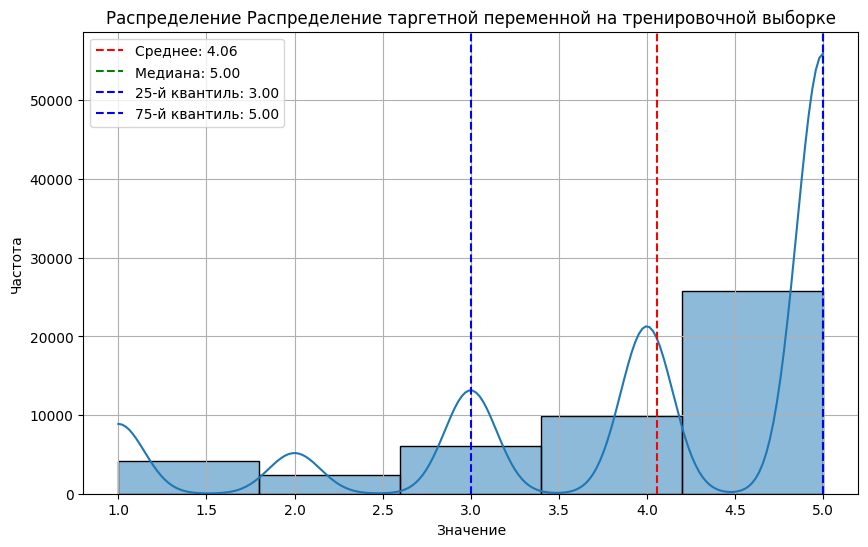

Epoch 1/30
95/95 [==============================] - ETA: 0s - loss: 1.0243 - precision: 0.7552 - recall: 0.4373 - f1-score: 0.3639  
Epoch 1: val_loss improved from inf to 1.28955, saving model to ./best_model_practice2.h5
95/95 [==============================] - 7s 51ms/step - loss: 1.0243 - precision: 0.7552 - recall: 0.4373 - f1-score: 0.3639 - val_loss: 1.2896 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1-score: 0.1396 - lr: 0.0010
Epoch 2/30
95/95 [==============================] - ETA: 0s - loss: 0.7571 - precision: 0.7842 - recall: 0.5980 - f1-score: 0.5105
Epoch 2: val_loss improved from 1.28955 to 1.19463, saving model to ./best_model_practice2.h5
95/95 [==============================] - 4s 43ms/step - loss: 0.7571 - precision: 0.7842 - recall: 0.5980 - f1-score: 0.5105 - val_loss: 1.1946 - val_precision: 0.6537 - val_recall: 0.4846 - val_f1-score: 0.1396 - lr: 0.0010
Epoch 3/30
95/95 [==============================] - ETA: 0s - loss: 0.5954 - precision: 0.8181

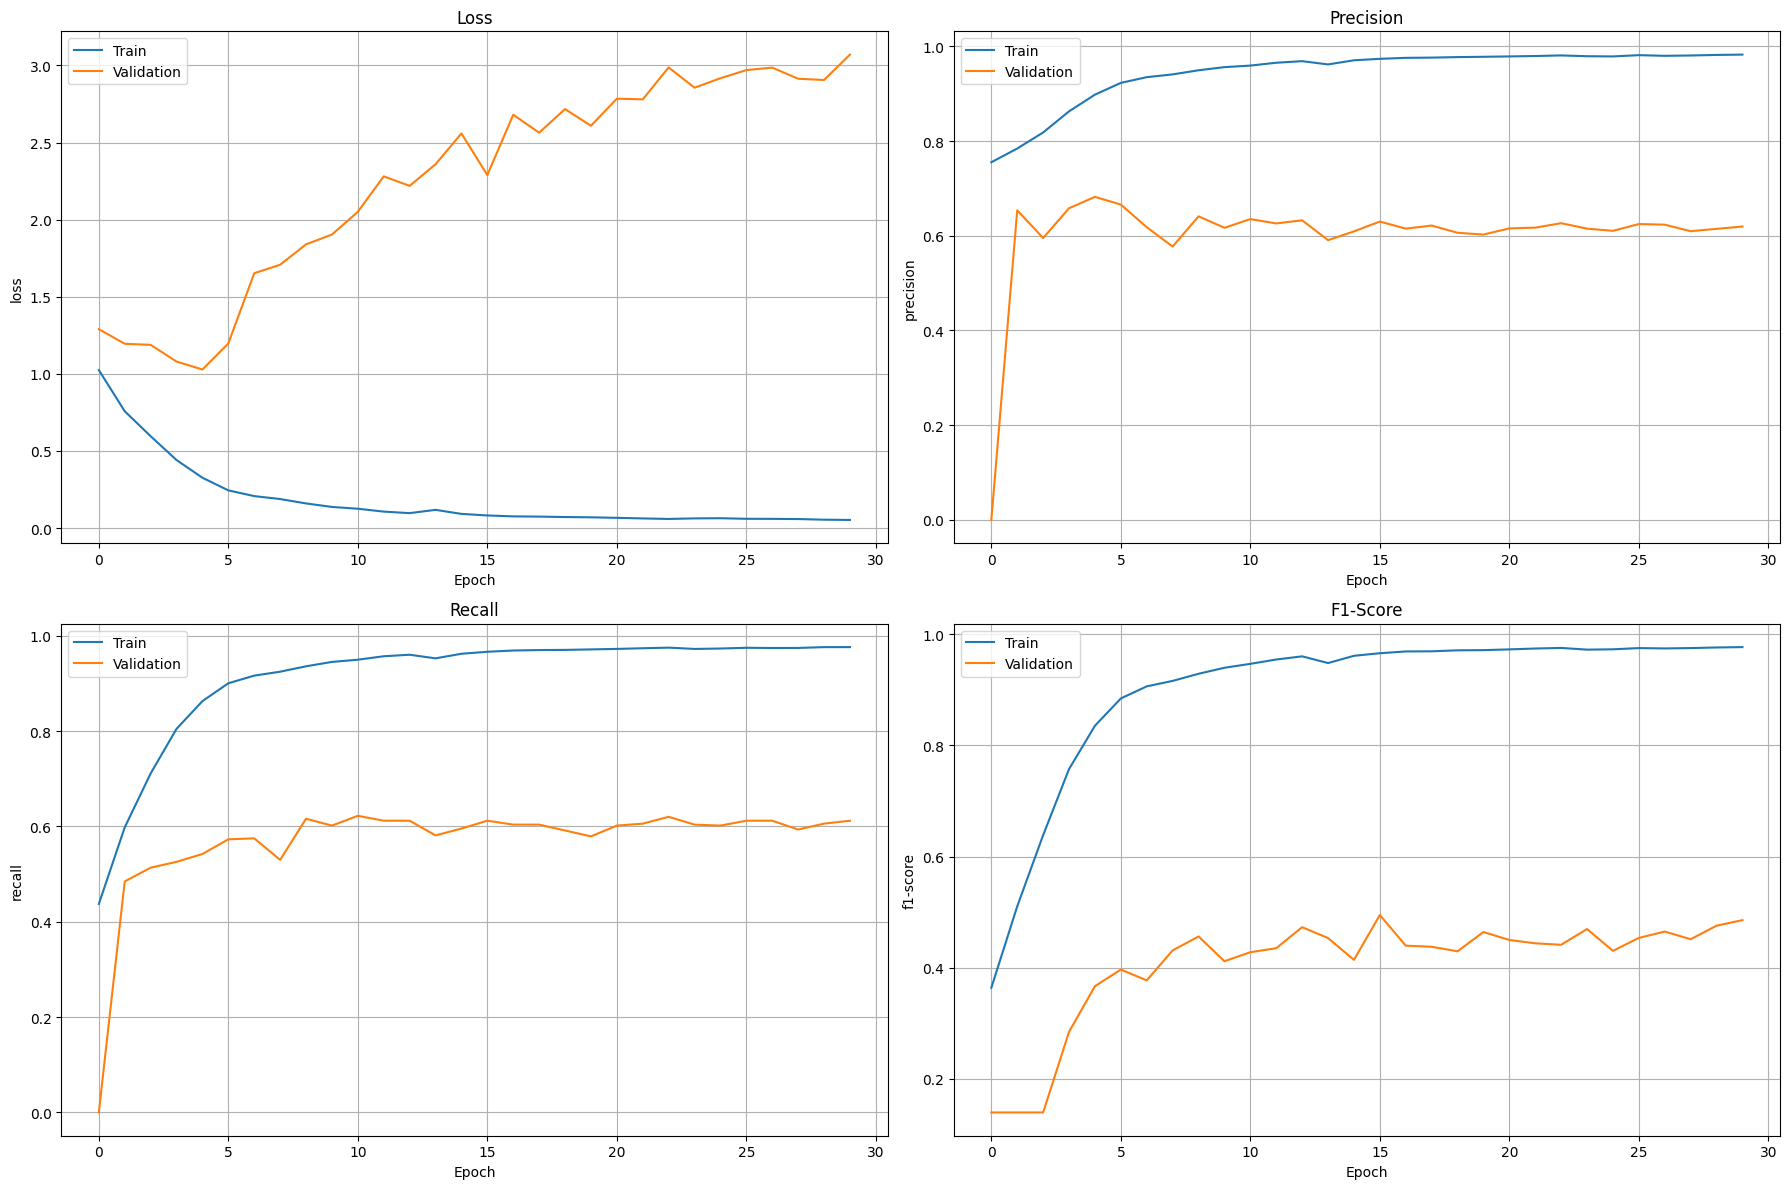

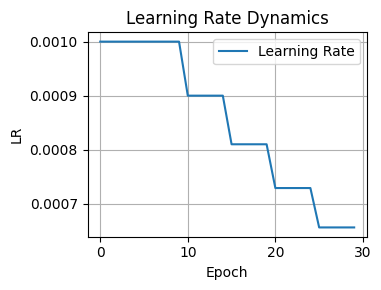

381/381 [==============================] - 3s 7ms/step


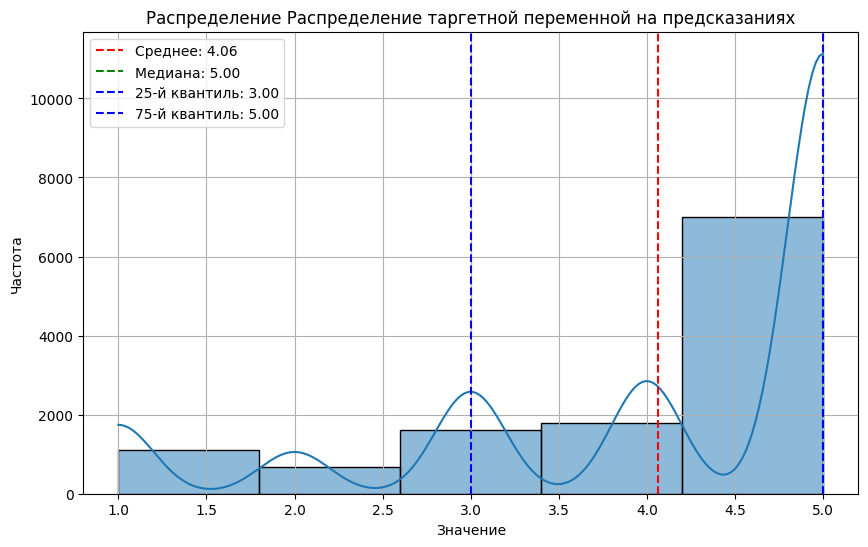

In [419]:
main()